# Aim
##### The goal of this kernel is to examine the data, derive some insights, and attempt to build a predictive model. 

# Importing the necessary several useful packages to load

In [ ]:
#First, let's load 
#NumPy: NumPy is the fundamental package for array computing with Python.
#pandas: pandas is a fast, powerful, flexible and easy to use open source data analysis and
import pandas as pd 
import numpy as np 

# importing vectorizers to convert word to vectors
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer

#use automated ML pipelines to improve ML models 
from sklearn.pipeline import Pipeline

# imoprting machine learning models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC 
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier 

# GridSearchCV Hyperparameter Tuning | ML
from sklearn.model_selection import GridSearchCV

# import nltk libraries for data cleaning 
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.corpus import stopwords
import string
import re 

# Predicting the results 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

# for visual representation 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Description
#### I collected the data from kaggle.
https://www.kaggle.com/shivamb/tf-idf-with-ovr-svm-what-s-cooking/data

In [2]:
dataset = pd.read_csv("/Users/vamshikrishna/Downloads/cuisine_data.csv")
dataset.head()

,cuisine_description,cuisine
0,romaine lettuce black olives grape tomatoes ga...,greek
1,plain flour ground pepper salt tomatoes ground...,southern_us
2,eggs pepper salt mayonaise cooking oil green c...,filipino
3,water vegetable oil wheat salt,indian
4,black pepper shallots cornflour cayenne pepper...,indian


- A cuisine is a type of cooking that is distinguished by distinctive ingredients, techniques, and dishes and is typically associated with a specific culture or geographic region. Regional food preparation traditions, customs, and ingredients frequently combine to create dishes that are unique to a particular regionc(country).

- In this competition, the model should be able to determine which country a cuisine belongs to based on its ingredients and techniques.


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cuisine_description  39774 non-null  object
 1   cuisine              39774 non-null  object
dtypes: object(2)
memory usage: 621.6+ KB


In [4]:
dataset.shape

(39774, 2)

In [5]:
dataset["cuisine"].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

* It appears to be quite simple - just ID, cuisine description, and (target) cuisine. The data set is a good size - 39774 rows should be enough for a good text classifier.

- Let us look at the target variable: 20 classes, but the first ten countries have samples ranging from 1100 to 7900, while the last ten have samples ranging from 400 to 1000, indicating that the target is severely unbalanced.

In [6]:
dataset.isnull().sum()

cuisine_description    0
cuisine                0
dtype: int64

* isnull Return the specified value If the expression is NULL, return it; otherwise, return the expression:
* there are no null values in the columns 

# Categorical Encoding 
- By identifying distinct values, the pandas.factorize() method assists in obtaining the numeric representation of an array.

In [7]:
dataset['cuisilabels'] = dataset['cuisine'].factorize()[0]
dataset.head()

,cuisine_description,cuisine,cuisilabels
0,romaine lettuce black olives grape tomatoes ga...,greek,0
1,plain flour ground pepper salt tomatoes ground...,southern_us,1
2,eggs pepper salt mayonaise cooking oil green c...,filipino,2
3,water vegetable oil wheat salt,indian,3
4,black pepper shallots cornflour cayenne pepper...,indian,3


In [8]:
dataset2 = dataset.sort_values(by=['cuisilabels']).drop_duplicates('cuisine')
dataset2

,cuisine_description,cuisine,cuisilabels
0,romaine lettuce black olives grape tomatoes ga...,greek,0
25848,eggs self rising flour brown sugar vanilla ext...,southern_us,1
29896,sugar corn starch salt water soy sauce broth,filipino,2
11840,vegetable oil fresh lime juice cilantro leaves...,indian,3
23025,ground cinnamon garlic powder crushed red pepp...,jamaican,4
37149,tumeric green onions salt shrimp mussels mince...,spanish,5
16865,freshly grated parmesan vegetable broth semi p...,italian,6
39707,shredded cheddar cheese boneless skinless chic...,mexican,7
14966,soy sauce honey salt pork butt hamburger buns ...,chinese,8
36577,turnips milk dry white wine lamb shoulder carr...,british,9


- 20 classes (countries) are represented by numerical values ranging from 0 to 20.

# Data Visualization

<AxesSubplot:xlabel='cuisine'>

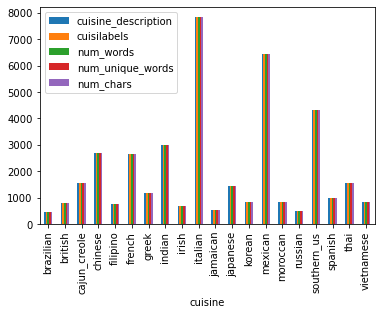

In [11]:
dataset.groupby('cuisine').count().plot.bar(ylim=0)

In [13]:
## Number of words in the text
dataset["num_words"] = dataset["cuisine_description"].apply(lambda x: len(str(x).split()))
## Number of unique words in the text 
dataset["num_unique_words"] = dataset["cuisine_description"].apply(lambda x: len(set(str(x).split())))
## Number of characters in the text ##
dataset["num_chars"] = dataset["cuisine_description"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
dataset["num_stopwords"] = dataset["cuisine_description"].apply(lambda x: len([w for w in str(x).lower().split() if w in set(stopwords.words('english'))]))

## Number of punctuations in the text ##
dataset["num_punctuations"] =dataset['cuisine_description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
## Number of title case words in the text ##
dataset["num_words_upper"] = dataset["cuisine_description"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

In [14]:
dataset

,cuisine_description,cuisine,cuisilabels,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper
0,romaine lettuce black olives grape tomatoes ga...,greek,0,16,16,116,0,0,0
1,plain flour ground pepper salt tomatoes ground...,southern_us,1,19,16,121,0,0,0
2,eggs pepper salt mayonaise cooking oil green c...,filipino,2,20,19,135,0,0,0
3,water vegetable oil wheat salt,indian,3,5,5,30,0,0,0
4,black pepper shallots cornflour cayenne pepper...,indian,3,33,32,221,0,0,0
...,...,...,...,...,...,...,...,...,...
39769,light brown sugar granulated sugar butter warm...,irish,16,24,21,157,0,2,0
39770,kraft zesty italian dressing purple onion broc...,italian,6,18,17,125,0,0,0
39771,eggs citrus fruit raisins sourdough starter fl...,irish,16,17,16,110,0,0,0
39772,boneless chicken skinless thigh minced garlic ...,chinese,8,45,42,296,0,0,0


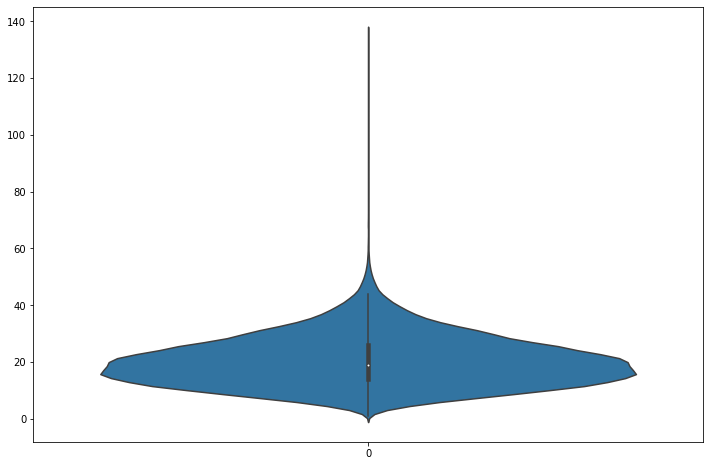

In [15]:
plt.figure(figsize=(12,8))
sns.violinplot(data=dataset['num_words'])
plt.show()

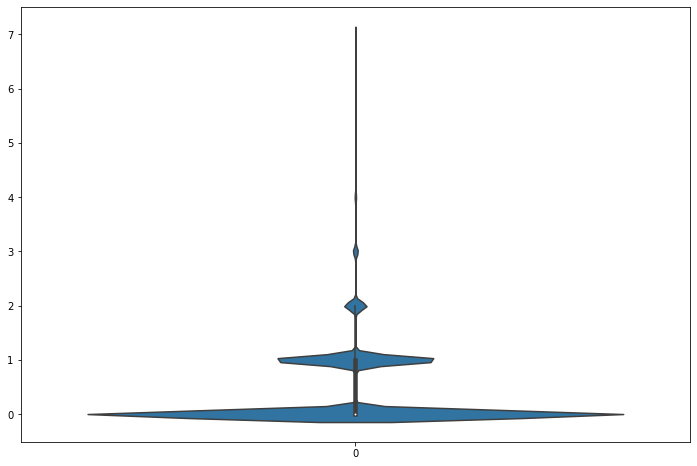

In [16]:
plt.figure(figsize=(12,8))
sns.violinplot(data=dataset['num_punctuations'])
plt.show()

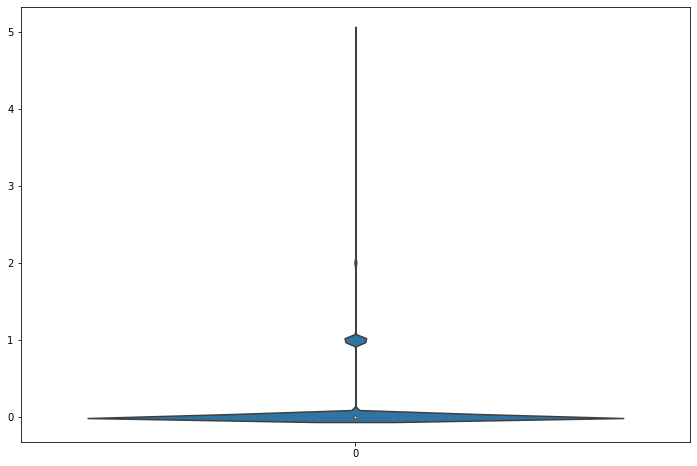

In [17]:
plt.figure(figsize=(12,8))
sns.violinplot(data=dataset["num_stopwords"])
plt.show()

* Using this visualisation, we were able to count how many stopwords and punctuations there are.


# Exploratory data analysis

In [18]:
def clean_words(cuisine_des):
    cuisine_des = cuisine_des.lower()
    cuisine_des = re.sub('[^A-Za-z0-9]+', ' ', cuisine_des)
    cuisine_des = re.sub("[.!”\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]","", cuisine_des)
    return cuisine_des

dataset['cuisine_description'] = dataset['cuisine_description'].apply(clean_words)

- This function takes a match for any character between a and z, lower case OR upper case, and removes all punctuation and special characters.

In [19]:
# removing the stop words 
dataset['cuisine_description'] = dataset['cuisine_description'].apply(lambda x: ' '.join([word for word in x.split() 
                                                                                          if word not in set(stopwords.words('english'))]))

In [20]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [21]:
#import contractions
#print(contractions.fix("you've")) 

##### Expanding English language contractions 
- They're usually constructed by deleting one of the word's vowels.

In [22]:
conm = CONTRACTION_MAP
def contraction_remove(cuisine_text):
    for key,value in conm.items():
        cuisine_text = re.sub(r"{}".format(key),'{}'.format(value), cuisine_text)
        
    return cuisine_text

dataset['cuisine_description'] = dataset['cuisine_description'].apply(contraction_remove)

##### Lemmatization is a mechanism for switching any kind of word to its basic root mode in its simplest form. 
- The base form of 'troubled' is clearly identified as 'trouble' conveying some meaning through lemmatization

In [23]:
lemmatizer = WordNetLemmatizer()
def lemmatization(cuisine_des):
    cuisine_des = ' '.join([lemmatizer.lemmatize(word) for word in cuisine_des.split(' ')])
    return cuisine_des
dataset['cuisine_description'] = dataset['cuisine_description'].apply(lemmatization)
# dataset.loc[:, 'cuisine_description'].apply(lemmatization) 

# Splitting the data into train and test

In [24]:
X = dataset["cuisine_description"]
y = dataset['cuisilabels']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3,
                                                    random_state=0, shuffle=True)

In [25]:
print("Train shape: ", x_train.shape)
print("Test shape: ", x_test.shape)

Train shape:  (27841,)
Test shape:  (11933,)


# Model building and tokenization

##### converting words to vectors 
- The TF-IDF can be used to assign vectors to either words or documents. 
Word2Vec can be used directly to assign a vector to a word, but further processing is required to obtain the vector representation of a document. 
- Tf-idf is a word scoring technique that determines how essential a word is in a document. 

##### Pipeline
* Pipelines are machine learning methods that make combining many algorithms into a single pipeline, or workflow, much easier. 

##### model 
- SVM  Classification

In [39]:
classifier = Pipeline([('tfidf',TfidfVectorizer()), ('classifier', SVC(C=10, gamma="scale", probability=True))])

In [40]:
# fit the data to model
classifier.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', SVC(C=10, probability=True))])

# Results prediction

In [41]:
y_pred = classifier.predict(x_test)

In [42]:
y_pred 

array([7, 7, 3, ..., 1, 1, 2])

- Returns the sample's probability for each class in the model.

In [43]:
pred_test_y = classifier.predict_proba(x_test)

In [47]:
print(pred_test_y)

[[3.46781452e-07 4.06449689e-06 6.54740100e-07 ... 7.55775566e-07
  7.75853996e-07 1.78245535e-06]
 [6.23016076e-04 4.48062956e-03 2.51385751e-03 ... 3.49453109e-03
  5.18470284e-04 1.27110460e-03]
 [2.60118182e-01 2.14382951e-02 1.69081605e-02 ... 4.98766418e-03
  1.50849669e-02 3.12687536e-02]
 ...
 [2.46769087e-05 9.55439098e-01 2.00685482e-05 ... 3.72206591e-05
  9.00485514e-06 1.34197462e-04]
 [4.78166131e-04 8.67753700e-01 1.72470712e-03 ... 1.10472097e-03
  1.14701761e-02 2.48015587e-03]
 [3.20468607e-03 9.92141914e-03 7.46164532e-01 ... 1.98920272e-03
  1.51580092e-03 1.07288492e-02]]


# Testing the Accuracy of predictive Models

##### Accuracy_score
- This function computes subset accuracy in multilabel classification: the set of labels predicted for a sample must 
exactly match the corresponding set of labels in y_true.
* accuracy_score= correct predictions/number of predictions

In [48]:
accuracy_score(y_test, y_pred)

0.8099388251068466

- A Confusion matrix is a N x N matrix that is used to assess the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values to the machine learning model's predictions. 
- 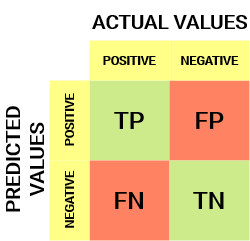
- 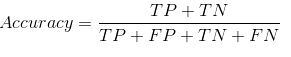!

In [49]:
confusion_matrix(y_test, y_pred)

array([[ 255,    8,    1,    3,    0,    5,   61,    4,    0,    0,    0,
           0,    0,    0,    8,    0,    1,    0,    5,    0],
       [   0, 1063,    1,   10,    2,    3,   60,   32,    6,   11,    1,
           0,   58,    0,   29,    1,    9,    0,    2,    3],
       [   1,   17,  146,    2,    0,    2,    7,    7,   19,    1,    4,
           3,    2,    1,    4,    2,    1,    0,    0,    0],
       [   5,    8,    2,  871,    2,    3,    6,   12,    1,    2,    7,
           1,    0,    1,    3,    8,    0,    0,   12,    2],
       [   0,   14,    4,    6,  125,    2,    3,    5,    4,    4,    1,
           0,    2,    2,    3,    1,    0,    0,    0,    0],
       [   5,   12,    1,    6,    1,  159,   55,   26,    1,    0,    0,
           2,    5,    3,   27,    0,    1,    0,    3,    2],
       [  37,   47,    1,    7,    0,   14, 2100,   15,    2,    4,    1,
           1,    6,    0,   88,    1,    3,    0,    4,    6],
       [   4,   47,    8,   11,    2,    

 - Sklearn classification_report() outputs precision, recall and f1-score for each target class. In addition to this, it also has some extra values: micro avg, macro avg, and weighted avg 
 
 https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       351
           1       0.72      0.82      0.77      1291
           2       0.78      0.67      0.72       219
           3       0.87      0.92      0.90       946
           4       0.91      0.71      0.80       176
           5       0.72      0.51      0.60       309
           6       0.82      0.90      0.86      2337
           7       0.91      0.92      0.92      1932
           8       0.82      0.88      0.85       818
           9       0.69      0.56      0.62       241
          10       0.81      0.81      0.81       474
          11       0.72      0.60      0.66       242
          12       0.78      0.71      0.74       448
          13       0.87      0.56      0.68       144
          14       0.66      0.70      0.68       795
          15       0.86      0.72      0.78       414
          16       0.76      0.54      0.63       190
          17       0.88    

In [55]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
def print_score(clf, x_train, x_test, y_train, y_test, train=True):
    '''
    v0.1 Follow the scikit learn library format in terms of input
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_train)
    if train:
        '''
        training performance
        '''
        res = clf.predict(x_train)
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, 
                                                                res)))
        print("Classification Report: \n {}\n".format(classification_report(y_train, 
                                                                            res)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, 
                                                                  res)))
        print("ROC AUC: {0:.4f}\n".format(roc_auc_score(lb.transform(y_train), 
                                                      lb.transform(res))))

        res = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        '''
        test performance
        '''
        res_test = clf.predict(x_test)
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, 
                                                                res_test)))
        print("Classification Report: \n {}\n".format(classification_report(y_test, 
                                                                            res_test)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, 
                                                                  res_test)))   
        print("ROC AUC: {0:.4f}\n".format(roc_auc_score(lb.transform(y_test), 
                                                      lb.transform(res_test))))

In [57]:
print_score(classifier, x_train, x_test, y_train, y_test, train=False)

Test Result:

accuracy score: 0.8099

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.73      0.76       351
           1       0.72      0.82      0.77      1291
           2       0.78      0.67      0.72       219
           3       0.87      0.92      0.90       946
           4       0.91      0.71      0.80       176
           5       0.72      0.51      0.60       309
           6       0.82      0.90      0.86      2337
           7       0.91      0.92      0.92      1932
           8       0.82      0.88      0.85       818
           9       0.69      0.56      0.62       241
          10       0.81      0.81      0.81       474
          11       0.72      0.60      0.66       242
          12       0.78      0.71      0.74       448
          13       0.87      0.56      0.68       144
          14       0.66      0.70      0.68       795
          15       0.86      0.72      0.78       414
          16      

In [ ]:
print_score(classifier, x_train, x_test, y_train, y_test, train=True)

Train Result:

accuracy score: 0.9994

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       824
           1       1.00      1.00      1.00      3029
           2       1.00      1.00      1.00       536
           3       1.00      1.00      1.00      2057
           4       1.00      1.00      1.00       350
           5       1.00      1.00      1.00       680
           6       1.00      1.00      1.00      5501
           7       1.00      1.00      1.00      4506
           8       1.00      1.00      1.00      1855
           9       1.00      1.00      1.00       563
          10       1.00      1.00      1.00      1065
          11       1.00      1.00      1.00       583
          12       1.00      1.00      1.00      1098
          13       1.00      1.00      1.00       323
          14       1.00      1.00      1.00      1851
          15       1.00      1.00      1.00      1009
          16     